### Imports and class definitions

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [108]:
#trial_info classs
class trial_info:
    def __init__(self, datapath):
        self.data = pd.read_csv(datapath)
        self.trial_types = ["Auditory Hit", "Auditory Miss","Whisker Hit", 
                            "Whisker Miss", "False Alarm", "Correct Rejection"]
        self._trial_index = None
        self._num_trials = None
        
    @property
    def trial_index(self):
        ah_idx = np.where(self.data["ah"] == 1)[0]
        am_idx = np.where(self.data["am"] == 1)[0]
        wh_idx = np.where(self.data["wh"] == 1)[0]
        wm_idx = np.where(self.data["wm"] == 1)[0]
        fa_idx = np.where(self.data["fa"] == 1)[0]
        cr_idx = np.where(self.data["cr"] == 1)[0]
        
        all_idx = [ah_idx, am_idx, wh_idx, wm_idx, fa_idx, cr_idx]
        
        self._trial_index = {self.trial_types[i]: all_idx[i] for i in range(len(self.trial_types))}
        
        return self._trial_index
    
    @property
    def num_trials(self):
        if self._trial_index == None:
            _ = self.trial_index
            
        self._num_trials = {key: len(self._trial_index[key]) for key in self._trial_index}
            
        return self._num_trials

#neuron_info classs
class neuron_info:
    def __init__(self, datapath):
        self.data = pd.read_csv(datapath)
        self.n_neurons = self.data.shape[0]
        self.areas = self.data["area"].unique()
        self._area_idx = None
        self._n_neurons_area = None
    
    @property
    def area_idx(self):
        self._area_idx = {area: np.where(self.data["area"] == area)[0] for area in self.areas}
        
        return self._area_idx
    
    @property
    def n_neurons_area(self):
        if self._area_idx == None:
            _, self.area_idx
        
        self._n_neurons_area = {area: len(self.area_idx[area]) for area in self.area_idx}
        
        return self._n_neurons_area
    

In [101]:
def filter_data(spike_bins, trial_inf, neuron_inf, trial_types, areas):
    if not isinstance(trial_inf, trial_info):
        raise ValueError(f"Expected trial inf to be of type __main__.neuron_info but got {type(trial_inf)} instead")
    
    if not isinstance(neuron_inf, neuron_info):
        raise ValueError(f"Expected trial inf to be of type __main__.trial_info but got {type(trial_inf)} instead")
        
    if not isinstance(areas, list):
        raise ValueError(f"areas to be of type list but got {type(areas)} instead")
        
    if not isinstance(trial_types, list):
        raise ValueError(f"trial_types to be of type list but got {type(areas)} instead")

        
    f_data = {}
    for trial_type in trial_types:
        if trial_type not in trial_inf.trial_types:
            raise NameError(f"Trial type can only be one of the following: {trial_inf.trial_types}")
        
        else:
            f_data[trial_type] = {}
            trial_type_idx = trial_inf.trial_index[trial_type]
            for area in areas:
                if area not in neuron_inf.areas:
                    print(area)
                    raise NameError(f"Area can only be one of the following: {neuron_inf.areas}")
                    
                else:
                    area_idx = neuron_inf.area_idx[area]
                    
                    
                    f_data[trial_type][area] = spike_bins[area_idx][:,trial_type_idx,:]
                    
    return f_data
                
                
    
    

### Loading data

In [110]:
trial_inf = trial_info(r"C:\Users\alex.legariamacal\Downloads\fwcajalproject\ab042_trial_data.csv")
neuron_inf = neuron_info(r"C:\Users\alex.legariamacal\Downloads\fwcajalproject\ab042_cluster_spike_times_2.csv")
spike_array = np.load(r"C:\Users\alex.legariamacal\Downloads\fwcajalproject\ab042_spikes_dense.npy")

In [119]:
ah_spikes = filter_data(spike_array, trial_inf, neuron_inf, ["Auditory Hit"], ["tjM1", "DLS"])["Auditory Hit"]
print(ah_spikes["DLS"].shape)
cr_spikes = filter_data(spike_array, trial_inf, neuron_inf, ["Correct Rejection"], ["tjM1", "DLS"])["Correct Rejection"]
print(cr_spikes["DLS"].shape)

(135, 83, 401)
(135, 211, 401)


In [123]:
ahtjm1 = ah_spikes["tjM1"][:,:,100:]
re_ahtjm1 = ahtjm1.reshape(166,-1)
mc_ahtjm1 = re_ahtjm1 - re_ahtjm1.mean(axis=1)

ahdls = ah_spikes["DLS"][:,:,100:]
re_dls = ahdls.reshape(166,-1)
mc_dls = re_ahdls - re_ahdls.mean(axis=1)


(166, 24983)

In [98]:

mc_tjm1 = re_tjm1 - re_tjm1.mean(axis=1)[:,np.newaxis]
mc_dls = re_dls - re_dls.mean(axis=1)[:,np.newaxis]

In [48]:
from sklearn.decomposition import PCA

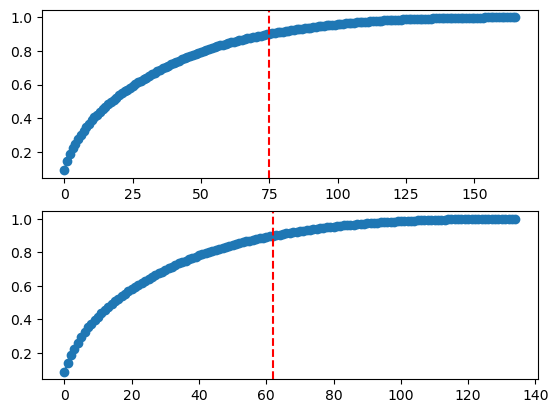

In [99]:
pca_tjm1 = PCA()
pca_tjm1.fit(mc_tjm1)

pca_dls = PCA()
pca_dls.fit(mc_dls)

fig, ax = plt.subplots(2,1)
ax[0].plot(np.cumsum(pca_tjm1.explained_variance_ratio_), marker="o")
ax[0].axvline(np.argmin(np.abs(np.cumsum(pca_tjm1.explained_variance_ratio_)-0.9)), linestyle="--", c="red")
ax[1].plot(np.cumsum(pca_dls.explained_variance_ratio_), marker="o")
ax[1].axvline(np.argmin(np.abs(np.cumsum(pca_dls.explained_variance_ratio_)-0.9)), linestyle="--", c="red")

In [19]:
n_latents = 80
pca_tjm1 = PCA(n_components=n_latents) # TODO: cross/validate train and test
proj_tjm1 = pca_tjm1.fit_transform(mc_tjm1.T)

pca_dls = PCA(n_components=n_latents)
proj_dls = pca_dls.fit_transform(mc_dls.T)

In [20]:
print(proj_tjm1.shape)
print(proj_dls.shape)

(24983, 70)
(24983, 70)


In [21]:
re_proj_tjm1 = proj_tjm1.reshape(-1,n_trials, n_latents)
re_proj_dls = proj_dls.reshape(-1,n_trials, n_latents)
print(re_proj_tjm1.shape)

(301, 83, 70)


In [23]:
from statsmodels.multivariate.cancorr import CanCorr
cc = CanCorr(proj_tjm1, proj_dls)

In [24]:
ccdims1 = cc.y_cancoef
ccdims2 = cc.x_cancoef

In [25]:
print(ccdims1.shape)
print(ccdims2.shape)

(70, 70)
(70, 70)


In [26]:
cc.cancorr.shape

(70,)

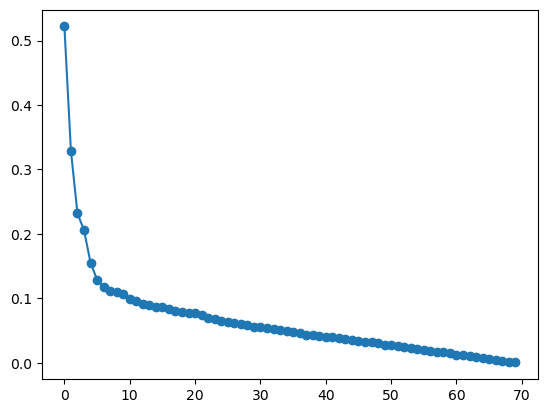

In [28]:
plt.plot(cc.cancorr, marker="o")

In [31]:
cc = CanCorr(proj_tjm1, proj_dls)

ccdims1 = cc.y_cancoef
ccdims2 = cc.x_cancoef

ccend_proj_tjm1 = proj_tjm1 @ ccdims1
ccexog_proj_dls = proj_dls @ ccdims2


print(ccend_proj_tjm1.shape)
print(ccexog_proj_dls.shape)

(24983, 70)
(24983, 70)


In [37]:
ccend_proj_tjm1_trials = ccend_proj_tjm1.reshape(-1,n_trials,n_latents)
ccexog_proj_dls_trials = ccexog_proj_dls.reshape(-1,n_trials,n_latents)
#print(ccend_proj_dls_trials.shape)

#ccend_proj_dls_trials[:,:,0].mean(axis=1).shape

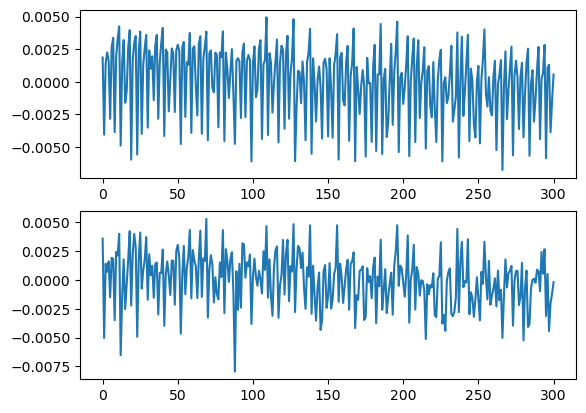

In [38]:
fig, ax = plt.subplots(2,1)
ax[0].plot(ccend_proj_tjm1_trials[:,:,0].mean(axis=1))
ax[1].plot(ccexog_proj_dls_trials[:,:,0].mean(axis=1))

In [39]:
np.corrcoef(ccend_proj_tjm1_trials[:,:,0].mean(axis=1), ccexog_proj_dls_trials[:,:,0].mean(axis=1))[0,1]

0.8044533419673088

In [40]:
all_corrs = {}
for i in range(70):
    c_corr = np.corrcoef(ccend_proj_tjm1_trials[:,:,i].mean(axis=1), ccexog_proj_dls_trials[:,:,i].mean(axis=1))[0,1]
    all_corrs[i] = c_corr
    

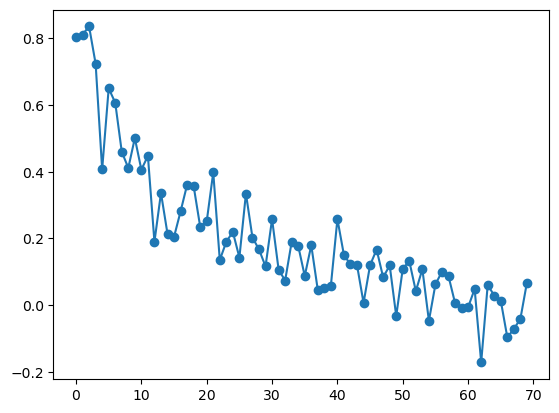

In [41]:
fig, ax = plt.subplots()
ax.plot(all_corrs.keys(), all_corrs.values(), marker="o")

In [ ]:
%matplotlib inline

cc_tjm1 = ccend_proj_tjm1_trials[:,:,:3]

print(cc_tjm1.shape)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)

ax.set_title('Unaligned - tjM1')

im = ax.scatter(re_proj_tjm1[:,0].mean(axis=1),
       re_proj_tjm1[:,1].mean(axis=1),
               c=np.linspace(0.2,0.8,301), s=5)

ax = fig.add_subplot(1,2,2)
ax.set_title('Aligned - tjM1')

im = ax.scatter(cc_tjm1[:,0].mean(axis=1),
       cc_tjm1[:,1].mean(axis=1),
                c=np.linspace(0.2,0.8,301), s=5)


cc_dls = ccend_proj_dls_trials[:,:,:3]


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)

ax.set_title('Unaligned - DLS')

im = ax.scatter(re_proj_dls[:,0].mean(axis=1),
       re_proj_dls[:,1].mean(axis=1),
               c=np.linspace(0.2,0.8,301), s=5)

ax = fig.add_subplot(1,2,2)
ax.set_title('Aligned - DLS')

im = ax.scatter(cc_dls[:,0].mean(axis=1),
       cc_dls[:,1].mean(axis=1),
                c=np.linspace(0.2,0.8,301), s=5)

In [ ]:
%matplotlib inline

cc_tjm1 = ccend_proj_tjm1_trials[:,:,:3]

print(cc_tjm1.shape)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1,projection="3d")

ax.set_title('Unaligned - tjM1')

im = ax.scatter(re_proj_tjm1[:,0].mean(axis=1),
       re_proj_tjm1[:,1].mean(axis=1),
       re_proj_tjm1[:,2].mean(axis=1),
               c=np.linspace(0.2,0.8,301))

ax = fig.add_subplot(1,2,2,projection="3d")
ax.set_title('Aligned - tjM1')

im = ax.scatter(cc_tjm1[:,0].mean(axis=1),
       cc_tjm1[:,1].mean(axis=1),
       cc_tjm1[:,2].mean(axis=1), 
                c=np.linspace(0.2,0.8,301))


cc_dls = ccend_proj_dls_trials[:,:,:3]


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1,projection="3d")

ax.set_title('Unaligned - DLS')

im = ax.scatter(re_proj_dls[:,0].mean(axis=1),
       re_proj_dls[:,1].mean(axis=1),
       re_proj_dls[:,2].mean(axis=1),
               c=np.linspace(0.2,0.8,301))

ax = fig.add_subplot(1,2,2,projection="3d")
ax.set_title('Aligned - DLS')

im = ax.scatter(cc_dls[:,0].mean(axis=1),
       cc_dls[:,1].mean(axis=1),
       cc_dls[:,2].mean(axis=1), 
                c=np.linspace(0.2,0.8,301))

In [ ]:
%matplotlib ipympl

cc_tjm1 = ccend_proj_tjm1_trials[:,:,:3].mean(axis=1)
cc_dls = ccexog_proj_dls_trials[:,:,:3].mean(axis=1)

print(cc_tjm1.shape)


fig = plt.figure()
ax = fig.add_subplot()

t_idx=0
im = ax.scatter(cc_tjm1[:,0],
       cc_tjm1[:,1],
               c=plt.get_cmap('Reds')(
    np.linspace(0.15, 0.85, 301)))

im = ax.scatter(cc_dls[:,0],
       cc_dls[:,1],
               c=plt.get_cmap('Greys')(
    np.linspace(0.15, 0.85, 301)))


